In [1]:
%matplotlib inline
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

In [2]:
from seas_flash_drougth_count_CMS import *

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.04/lib/python3.6/site-packages/xarray/core/options.py:50: FutureWarning: The enable_cftimeindex option is now a no-op and will be removed in a future version of xarray.
  FutureWarning)


In [3]:
filename = 'mrsos_day_CanESM2_historical_r1i1p1_18610101-20051231.nc'     
ds = xr.open_dataset(filename).sel(lat=slice(-60,-10),lon=slice(100,160))#.sel(time=slice('1861-01','1880-12'))
# ds = xr.open_dataset(filename, chunks={'lat':10,'lon':10})#.sel(time=slice('1861-01','1880-12'))
ds.mrsos

<xarray.DataArray 'mrsos' (time: 52925, lat: 18, lon: 21)>
[20005650 values with dtype=float32]
Coordinates:
  * time     (time) object 1861-01-01 12:00:00 ... 2005-12-31 12:00:00
  * lon      (lon) float64 101.2 104.1 106.9 109.7 ... 149.1 151.9 154.7 157.5
  * lat      (lat) float64 -60.0 -57.21 -54.42 -51.63 ... -18.14 -15.35 -12.56
    depth    float64 ...
Attributes:
    standard_name:     moisture_content_of_soil_layer
    long_name:         Moisture in Upper Portion of Soil Column
    units:             kg m-2
    comment:           the mass of water in all phases in a thin surface soil...
    original_name:     WGFL
    cell_methods:      time: mean (interval: 15 minutes) area: mean where land
    cell_measures:     area: areacella
    history:           2011-04-13T22:40:08Z altered by CMOR: Treated scalar d...
    associated_files:  baseURL: http://cmip-pcmdi.llnl.gov/CMIP5/dataLocation...

In [4]:
# Create a stacked (2D) version of the dataset, which creates a new axis call all,
# which is a combination of the lat and lon axes
mrsos_stack= ds.mrsos.stack(latlon=('lat','lon'))

In [5]:
mrsos_max = mrsos_stack.max(dim='time')

In [6]:
mrsos_min = mrsos_stack.min(dim='time')

In [7]:
%time mrsos_masked = mrsos_stack.where(mrsos_max != mrsos_min, drop=True)

CPU times: user 39 ms, sys: 34 ms, total: 73 ms
Wall time: 70.9 ms


In [8]:
mrsos_masked

<xarray.DataArray 'mrsos' (time: 52925, latlon: 91)>
array([[12.740191,  8.492062,  5.742531, ...,  7.866596,  9.260251, 12.316218],
       [12.547095,  8.194021,  5.671169, ..., 11.02191 , 14.055489, 12.5373  ],
       [11.927226,  7.785439,  5.539639, ..., 10.604933, 15.492521, 13.984127],
       ...,
       [ 6.225273,  4.460816,  4.884789, ...,  6.882922,  8.373125,  5.110069],
       [ 6.503725,  4.548969,  5.255591, ...,  6.440758, 10.097004,  6.667437],
       [ 6.349807,  4.518186,  5.100275, ...,  6.071355, 10.719671,  6.647848]],
      dtype=float32)
Coordinates:
  * time     (time) object 1861-01-01 12:00:00 ... 2005-12-31 12:00:00
    depth    float64 0.05
  * latlon   (latlon) MultiIndex
  - lat      (latlon) float64 -40.46 -37.67 -37.67 -37.67 ... -29.3 -29.3 -29.3
  - lon      (latlon) float64 146.2 140.6 143.4 146.2 ... 129.4 132.2 135.0
Attributes:
    standard_name:     moisture_content_of_soil_layer
    long_name:         Moisture in Upper Portion of Soil Column
    

In [9]:
%time percentiles = mrsos_masked.load().quantile([0.1,0.3,0.4],dim='time').rename('percentiles')
percentiles

CPU times: user 71 ms, sys: 0 ns, total: 71 ms
Wall time: 69.5 ms


<xarray.DataArray 'percentiles' (quantile: 3, latlon: 91)>
array([[ 8.594208,  5.976206,  6.023781, ...,  4.099809,  4.099809,  4.099809],
       [13.321162,  9.005588,  9.48721 , ...,  4.105406,  4.106805,  4.238335],
       [16.307726, 11.09607 , 11.992991, ...,  4.189361,  4.423037,  4.495798]])
Coordinates:
  * latlon    (latlon) MultiIndex
  - lat       (latlon) float64 -40.46 -37.67 -37.67 -37.67 ... -29.3 -29.3 -29.3
  - lon       (latlon) float64 146.2 140.6 143.4 146.2 ... 129.4 132.2 135.0
  * quantile  (quantile) float64 0.1 0.3 0.4

In [10]:
indices = np.reshape(np.tile(np.arange(mrsos_masked.shape[0]),mrsos_masked.shape[1]),mrsos_masked.shape,order='F')
indices.shape

(52925, 91)

In [11]:
%time moist_index = mrsos_masked.copy(data=indices)\
                          .where(mrsos_masked >= percentiles[1])\
                          .bfill('time')

CPU times: user 86 ms, sys: 23 ms, total: 109 ms
Wall time: 109 ms


In [12]:
moist_index = (moist_index - indices).shift(time=-1)

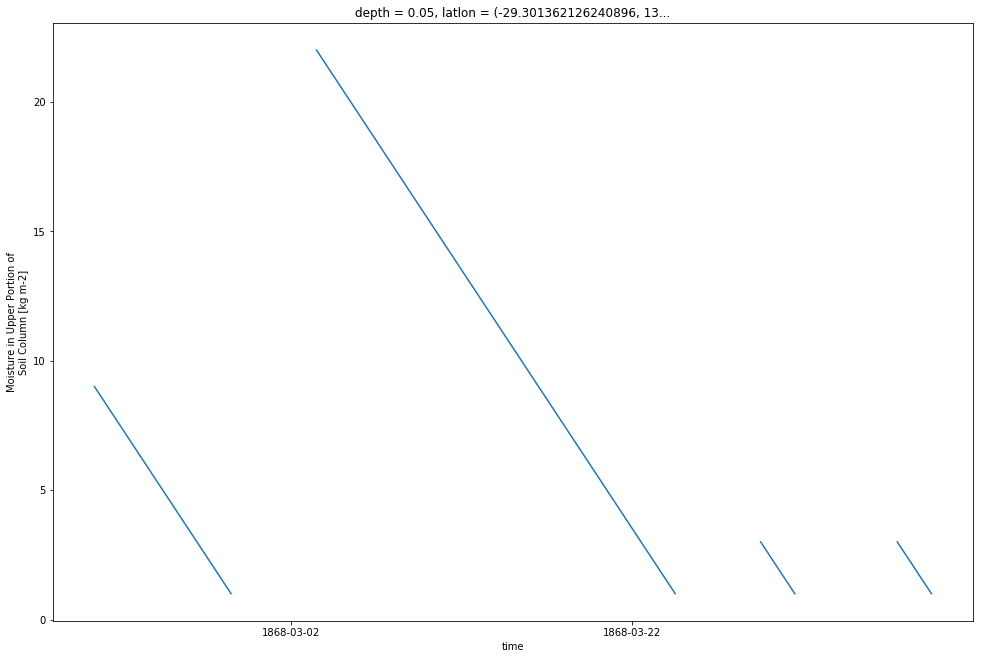

In [13]:
moist_index.where(moist_index > 0)[2600:2700,30].plot(size=11)

In [14]:
dt=14

Drought count calculates a rolling sum of window dt of how many locations in each window satisfy the drought criteria. This shifted backwards by dt-1 so that at a given point i drought_count > 1 signifies that there was a drought within dt of i

In [15]:
%time drought_count = (mrsos_masked<percentiles.values[0]).rolling(time=dt).sum().shift(time=-(dt+1))
# drought_count[2600:2700].plot(size=8)

CPU times: user 1.72 s, sys: 88 ms, total: 1.81 s
Wall time: 1.74 s


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.04/lib/python3.6/site-packages/bottleneck/slow/move.py:149: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  nidx1 = n[idx1]
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.04/lib/python3.6/site-packages/bottleneck/slow/move.py:150: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  nidx1 = nidx1 - n[idx2]
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.04/lib/python3.6/site-packages/bottleneck/slow/move.py:152: FutureWarning: Using a non-tuple sequence for multidimensional indexin

In [16]:
drought_count

<xarray.DataArray (time: 52925, latlon: 91)>
array([[ 7.,  0., 14., ...,  0.,  0.,  0.],
       [ 7.,  0., 14., ...,  0.,  0.,  0.],
       [ 8.,  0., 14., ...,  0.,  0.,  0.],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * time     (time) object 1861-01-01 12:00:00 ... 2005-12-31 12:00:00
    depth    float64 0.05
  * latlon   (latlon) MultiIndex
  - lat      (latlon) float64 -40.46 -37.67 -37.67 -37.67 ... -29.3 -29.3 -29.3
  - lon      (latlon) float64 146.2 140.6 143.4 146.2 ... 129.4 132.2 135.0

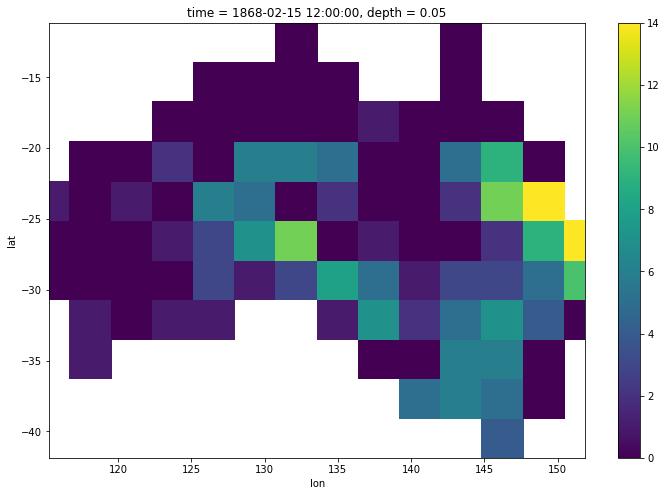

In [17]:
drought_count[2600,:].unstack().reindex(lon=sorted(drought_count.lon.values)).plot(size=8)

In [40]:
%time result = moist_index.where(mrsos_masked>=percentiles.values[2]).where(drought_count>0).compute()

CPU times: user 93 ms, sys: 45 ms, total: 138 ms
Wall time: 136 ms


In [41]:
# Remove the zero valued results, which are wet days with wet days immediately following
result = result.where(result>0)
result

<xarray.DataArray 'mrsos' (time: 52925, latlon: 91)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * time      (time) object 1861-01-01 12:00:00 ... 2005-12-31 12:00:00
    depth     float64 0.05
  * latlon    (latlon) MultiIndex
  - lat       (latlon) float64 -40.46 -37.67 -37.67 -37.67 ... -29.3 -29.3 -29.3
  - lon       (latlon) float64 146.2 140.6 143.4 146.2 ... 129.4 132.2 135.0
    quantile  float64 0.3
Attributes:
    standard_name:     moisture_content_of_soil_layer
    long_name:         Moisture in Upper Portion of Soil Column
    units:             kg m-2
    comment:           the mass of water in all phases in a thin surface soil...
    original_name:     WGFL
    cell_methods:      time: mean (interval: 15 minutes) area: mean whe

In [42]:
result = result.unstack().reindex(lon=sorted(result.lon.values)).compute()
result.to_netcdf('result.nc')

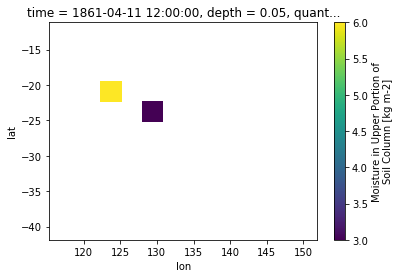

In [43]:
result[100,:].plot()

In [44]:
result.groupby('time.season').mean(dim='time').to_netcdf('result_season.nc')

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.04/lib/python3.6/site-packages/xarray/core/nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [98]:
ts = ds.mrsos.sel(lat=-15.348,lon=135.,method='nearest')
ts

<xarray.DataArray 'mrsos' (time: 52925)>
array([33.57086 , 28.42721 , 22.508371, ...,  4.095612,  4.999528,  5.119864],
      dtype=float32)
Coordinates:
  * time     (time) object 1861-01-01 12:00:00 ... 2005-12-31 12:00:00
    lon      float64 135.0
    lat      float64 -15.35
    depth    float64 ...
Attributes:
    standard_name:     moisture_content_of_soil_layer
    long_name:         Moisture in Upper Portion of Soil Column
    units:             kg m-2
    comment:           the mass of water in all phases in a thin surface soil...
    original_name:     WGFL
    cell_methods:      time: mean (interval: 15 minutes) area: mean where land
    cell_measures:     area: areacella
    history:           2011-04-13T22:40:08Z altered by CMOR: Treated scalar d...
    associated_files:  baseURL: http://cmip-pcmdi.llnl.gov/CMIP5/dataLocation...

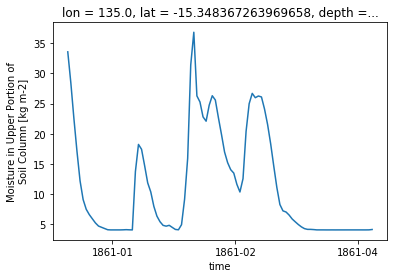

In [99]:
ts[0:100].plot()

In [100]:
tsperc = ts.quantile([0.1,0.3,0.4])
tsperc

<xarray.DataArray 'mrsos' (quantile: 3)>
array([4.09841 , 4.099809, 4.099809])
Coordinates:
  * quantile  (quantile) float64 0.1 0.3 0.4

(array([43808.,  2263.,  1075.,   841.,   814.,  1072.,  1781.,   772.,
          345.,   154.]),
 array([ 4.0900145,  7.362446 , 10.634877 , 13.907309 , 17.179739 ,
        20.452171 , 23.724602 , 26.997034 , 30.269464 , 33.541897 ,
        36.814327 ], dtype=float32),
 <a list of 10 Patch objects>)

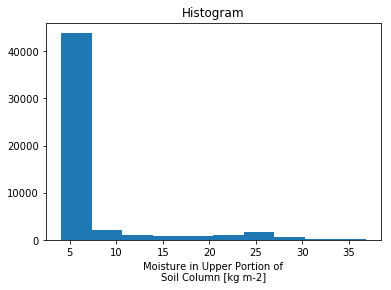

In [101]:
ts.plot.hist()

In [102]:
tsindices = data=np.arange(ts.shape[0])
ts_moist = ts.copy(data=tsindices).where(ts>=tsperc[1]).bfill(dim='time')-tsindices

In [103]:
ts_drought_count = (ts<tsperc.values[0]).rolling(time=dt).sum().shift(time=-(dt+1))

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.04/lib/python3.6/site-packages/bottleneck/slow/move.py:149: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  nidx1 = n[idx1]
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.04/lib/python3.6/site-packages/bottleneck/slow/move.py:150: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  nidx1 = nidx1 - n[idx2]
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.04/lib/python3.6/site-packages/bottleneck/slow/move.py:152: FutureWarning: Using a non-tuple sequence for multidimensional indexin

In [104]:
ts_drought_indices = ts.copy(data=tsindices).where(ts<tsperc[0]).bfill(dim='time')-tsindices

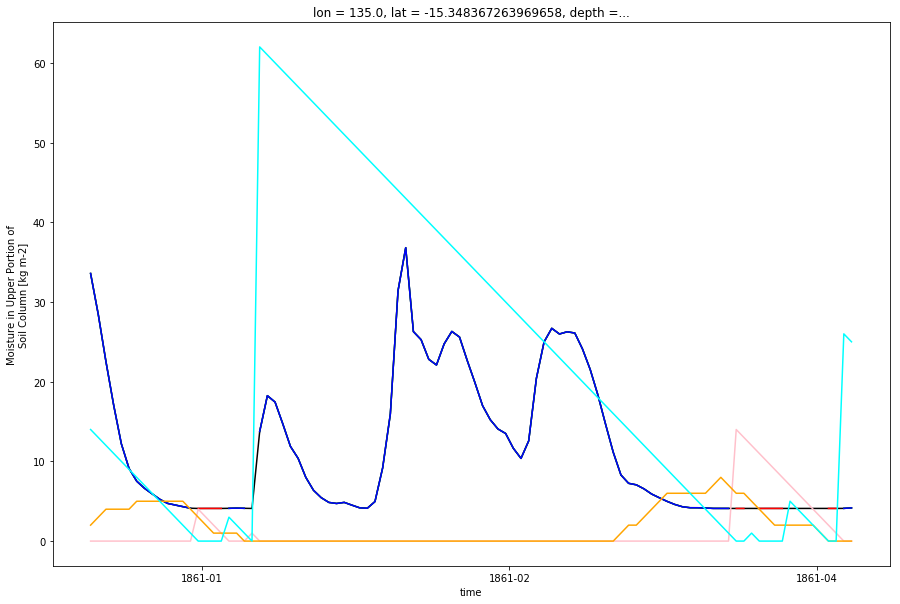

In [113]:
ts[0:100].plot(size=10,color='black')
ts[0:100].where(ts>=tsperc[1]).plot(color='green')
ts[0:100].where(ts>=tsperc[2]).plot(color='blue')
ts[0:100].where(ts<tsperc[0]).plot(color='red')
ts_moist[0:100].plot(color='pink')
ts_drought_count[0:100].plot(color='orange')
ts_drought_indices[0:100].plot(color='aqua')

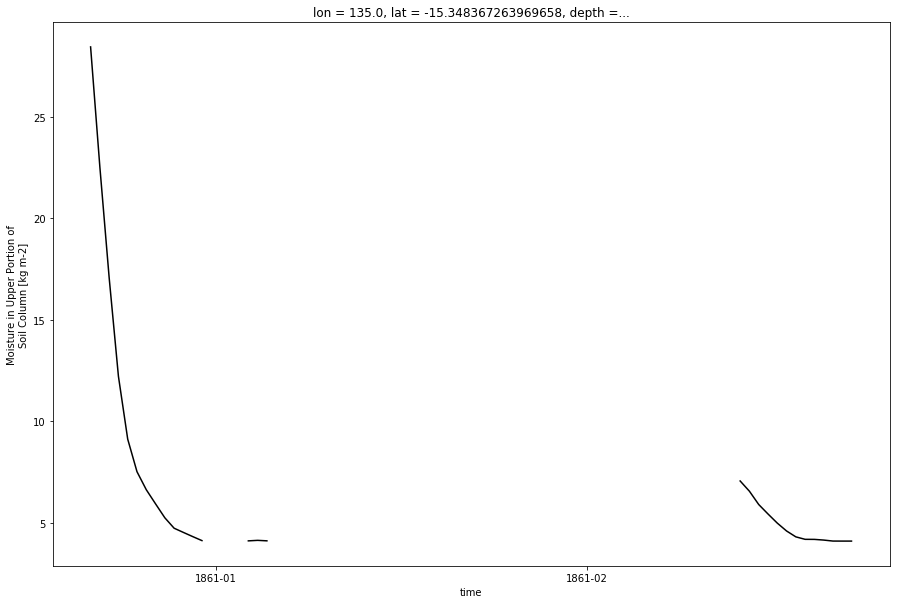

In [117]:
ts.where(ts>=tsperc[2]).where(ts_drought_indices<dt)[0:100].plot(size=10,color='black')

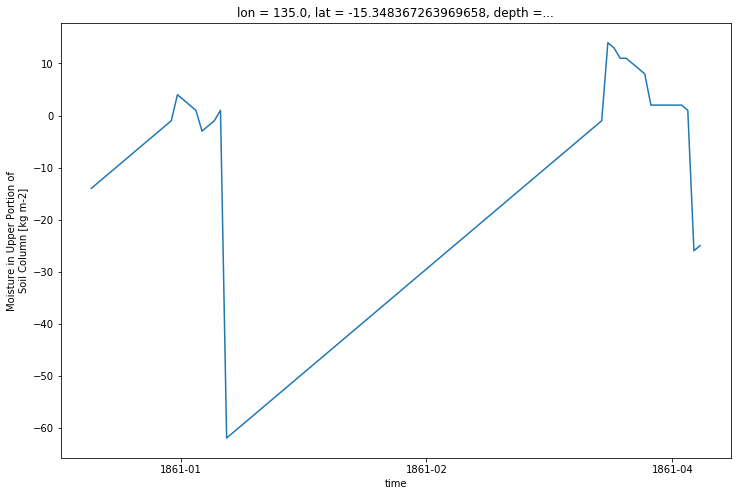

In [128]:
(ts_moist - ts_drought_indices)[0:100].plot(size=8)

In [106]:
ts_result = ts_moist.where(ts>=tsperc.values[2]).where(ts_drought_count>0).compute()

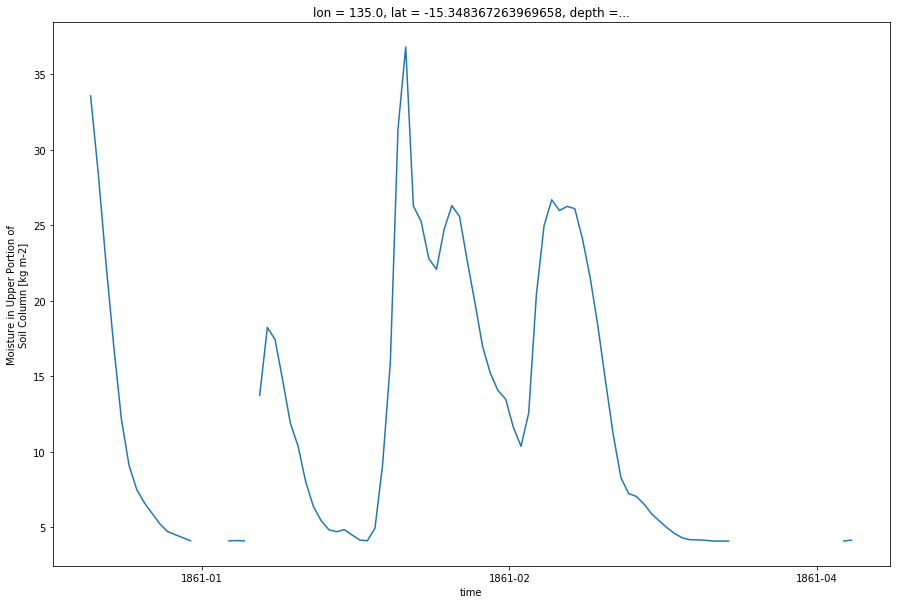

In [112]:
ts.where(ts>=tsperc.values[2])[0:100].plot(size=10)
ts_result.where(ts_moist>0)[0:100].plot(color='red')